# Exploratory Data Analysis: Article Classification Dataset

This notebook explores several datasets containing news articles labeled as fake or real. We analyze textual patterns, length distributions, and linguistic features to understand characteristics distinguishing the two classes.

## Analysis Goals
- Text length and complexity patterns
- Vocabulary differences between classes  
- Linguistic markers of reliability
- Class distribution and potential imbalance

In [4]:
import pandas as pd
import numpy as np

def combine_news_datasets(fake_path, true_path, final_en_path, welfake_path):
    # Load datasets
    fake_df = pd.read_csv(fake_path)
    true_df = pd.read_csv(true_path)
    final_en_df = pd.read_csv(final_en_path)
    welfake_df = pd.read_csv(welfake_path)

    # Fix fake labels for each dataset
    fake_df['fake'] = 1
    true_df['fake'] = 0
    final_en_df['fake'] = 1 - final_en_df['lebel']  # Convert 0=fake to 1=fake
    welfake_df['fake'] = welfake_df['label']

    # Select required columns and combine
    dfs = []
    for df in [fake_df, true_df, final_en_df, welfake_df]:
        df = df[['title', 'text', 'fake']].copy()
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Clean data
    combined_df['title'] = combined_df['title'].fillna('').str.strip()
    combined_df['text'] = combined_df['text'].fillna('').str.strip()
    
    # Drop rows with empty title or text
    combined_df = combined_df[
        (combined_df['title'] != '') & 
        (combined_df['text'] != '') &
        (~combined_df['title'].isna()) & 
        (~combined_df['text'].isna())
    ]
    
    # Drop duplicates based on title
    combined_df = combined_df.drop_duplicates(subset=['title'])
    
    # Convert fake to int
    combined_df['fake'] = combined_df['fake'].astype(int)
    
    return combined_df

df = combine_news_datasets('../data/Fake.csv', '../data/True.csv', '../data/final_en.csv', '../data/WELFake_Dataset.csv')
df.head()

,title,text,fake
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,1


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from scipy import stats

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/mot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mot/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/mot/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [6]:
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    
    return ' '.join(tokens)

def preprocess_dataset(df):
    # Clean text
    df['headline'] = df['title'].apply(preprocess_text)
    df['content'] = df['text'].apply(preprocess_text)
    
    # Additional features
    df['title_length'] = df['title'].str.len()
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['content'].str.split().str.len()
    
    return df

df = preprocess_dataset(df)
df.head()

,title,text,fake,headline,content,title_length,text_length,word_count
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,1,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,78,2893,276
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,68,1898,167
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",1,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,89,3597,319
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",1,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,77,2774,247
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,1,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,69,2346,209


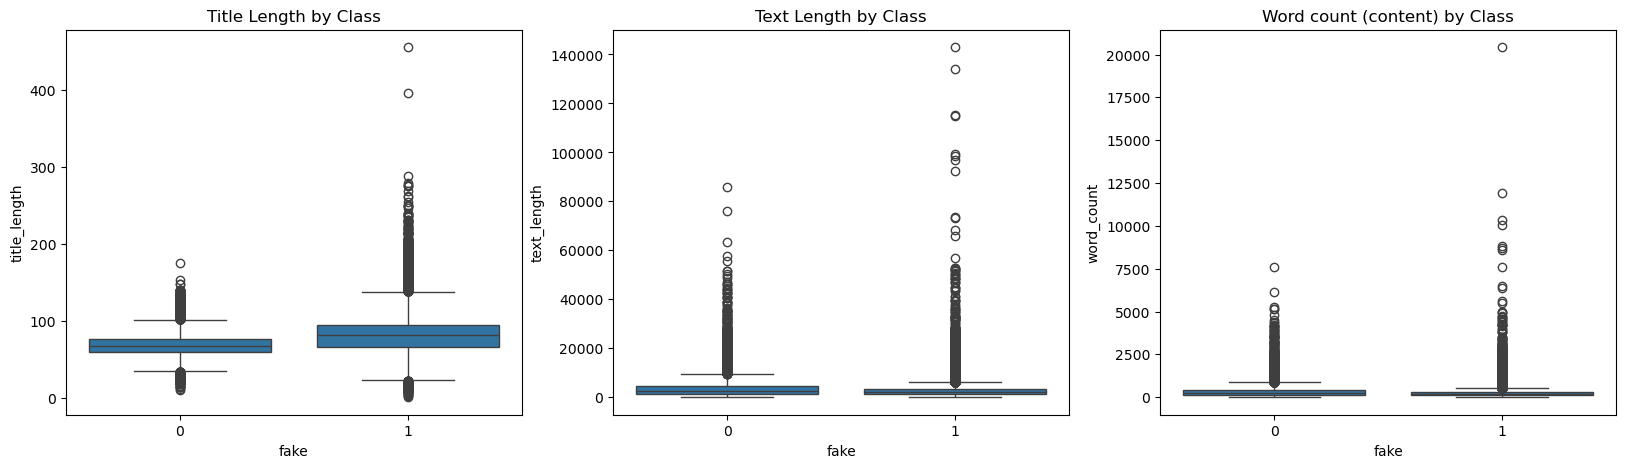

In [8]:
def text_length_distribution(df):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    sns.boxplot(x='fake', y='title_length', data=df, ax=ax1)
    sns.boxplot(x='fake', y='text_length', data=df, ax=ax2)
    sns.boxplot(x='fake', y='word_count', data=df, ax=ax3)
    ax1.set_title('Title Length by Class')
    ax2.set_title('Text Length by Class')
    ax3.set_title('Word count (content) by Class')

text_length_distribution(df)

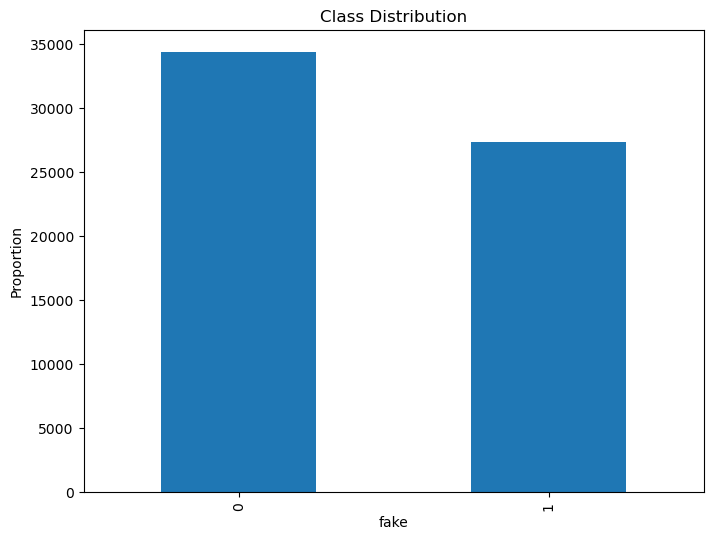

In [10]:
def class_distribution(df):
    plt.figure(figsize=(8, 6))
    df['fake'].value_counts(normalize=False).plot(kind='bar')
    plt.title('Class Distribution')
    plt.ylabel('Proportion')
    plt.gcf()

class_distribution(df)

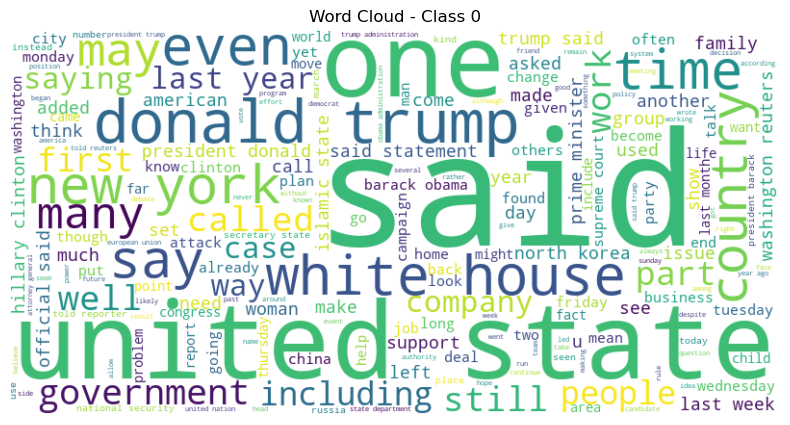

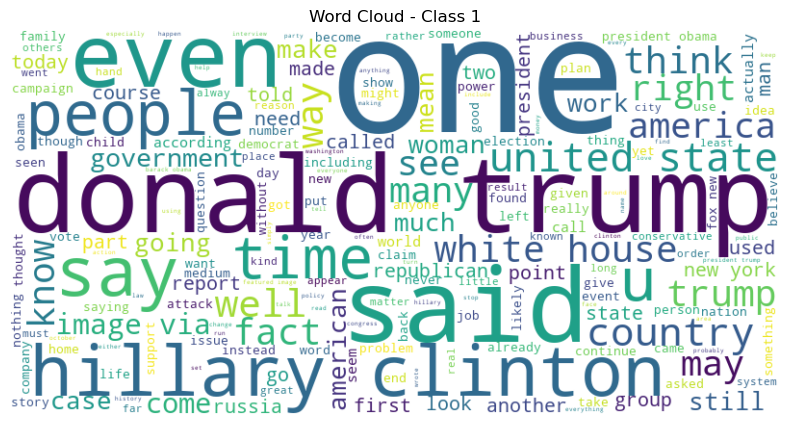

In [11]:
def generate_wordcloud(df, class_label):
    text = ' '.join(df[df['fake'] == class_label]['content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - Class {class_label}')
    plt.gcf()

generate_wordcloud(df, class_label=0)
generate_wordcloud(df, class_label=1)

In [12]:
def common_words_by_class(df, n_words=20):
    results = {}
    for label in df['fake'].unique():
        text = ' '.join(df[df['fake'] == label]['content'].str.lower())
        words = text.split()
        results[label] = pd.Series(Counter(words).most_common(n_words))
    return pd.DataFrame(results)

common_words_by_class(df)

,1,0
0,"(trump, 83744)","(said, 181463)"
1,"(people, 37258)","(trump, 104244)"
2,"(said, 34843)","(state, 67285)"
3,"(one, 34473)","(would, 61559)"
4,"(would, 32500)","(president, 49470)"
5,"(clinton, 32379)","(year, 44983)"
6,"(state, 30510)","(one, 42900)"
7,"(president, 27666)","(new, 41812)"
8,"(time, 25589)","(people, 41284)"
9,"(like, 24746)","(republican, 38190)"


Sentiment-label correlation: 0.004
Point-biserial correlation p-value: 0.338


np.float64(0.0038568219718477814)

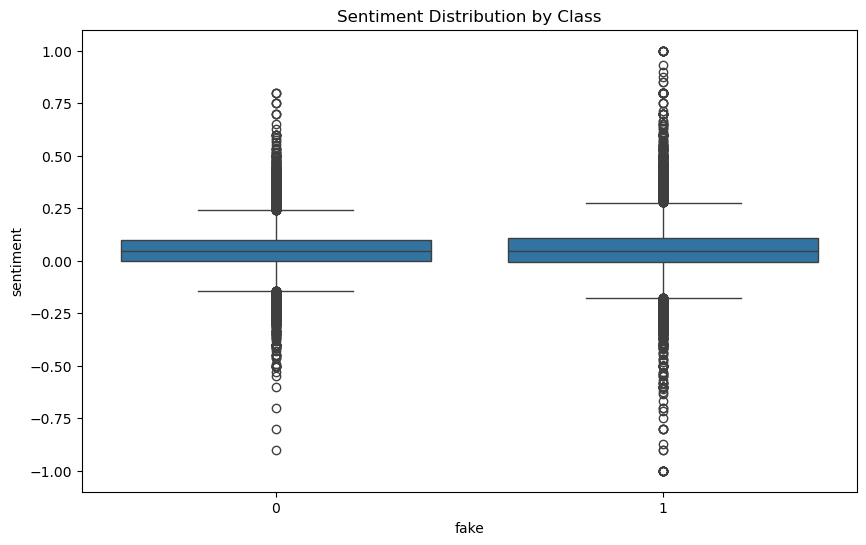

In [13]:
from textblob import TextBlob

def sentiment_analysis(df):
    df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='fake', y='sentiment', data=df)
    plt.title('Sentiment Distribution by Class')
    plt.gcf()

def analyze_sentiment_correlation(df):
   correlation = df['sentiment'].corr(df['fake'])
   print(f"Sentiment-label correlation: {correlation:.3f}")
   
   # Optional: Statistical test
   stat, p_value = stats.pointbiserialr(df['fake'], df['sentiment'])
   print(f"Point-biserial correlation p-value: {p_value:.3f}")
   
   return correlation

sentiment_analysis(df)
analyze_sentiment_correlation(df)

In [14]:
def remove_length_outliers(df, threshold_percentile=95):
   length_threshold = df['text_length'].quantile(threshold_percentile/100)
   df_filtered = df[df['text_length'] <= length_threshold].copy()
   print(f"{len(df) - len(df_filtered)} articles > {length_threshold} chars")
   return df_filtered

remove_length_outliers(df)

3088 articles > 8400.0 chars


,title,text,fake,headline,content,title_length,text_length,word_count,sentiment
0,Donald Trump Sends Out Embarrassing New Year’s...,Donald Trump just couldn t wish all Americans ...,1,donald trump sends embarrassing new year eve m...,donald trump wish american happy new year leav...,78,2893,276,0.101064
1,Drunk Bragging Trump Staffer Started Russian C...,House Intelligence Committee Chairman Devin Nu...,1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,68,1898,167,-0.013625
2,Sheriff David Clarke Becomes An Internet Joke ...,"On Friday, it was revealed that former Milwauk...",1,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,89,3597,319,-0.041640
3,Trump Is So Obsessed He Even Has Obama’s Name ...,"On Christmas day, Donald Trump announced that ...",1,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,77,2774,247,-0.011849
4,Pope Francis Just Called Out Donald Trump Duri...,Pope Francis used his annual Christmas Day mes...,1,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,69,2346,209,-0.000568
...,...,...,...,...,...,...,...,...,...
127007,Police Are Now Warning People To Take A Photo ...,November 2015 Ads Police Are Now Warning Peopl...,1,police warning people take photo hotel room ri...,november 2015 ad police warning people take ph...,101,3010,274,0.020254
127015,"Tested by Russia, NATO Struggles to Stay Credi...",BRUSSELS — Six weeks before a critical summ...,0,tested russia nato struggle stay credible new ...,brussels six week critical summit meeting aime...,70,7794,699,0.006281
127021,"Dallas, Roger Federer, Hillary Clinton: Your F...",(Want to get this briefing by email? Here’s th...,0,dallas roger federer hillary clinton friday ev...,want get briefing email good evening latest 1 ...,89,4201,392,0.013857
127022,An Unlikely Contender Rises in France as the A...,"PARIS — In the age of Donald J. Trump, “Bre...",0,unlikely contender rise france antithesis trum...,paris age donald trump brexit resurgent french...,85,7229,639,0.047732


# Key Findings

1. **Title Length**: Strong predictor for classification

2. **Content Length Distribution**
  - May remove outliers > 95th percentile (>8400 chars)

3. **Sentiment Analysis**
  - Sentiment appears to be a poor predictor of whether news is fake or real since there's no meaningful correlation between them.